<h2 style="color:red">Summary</h2>

This analysis involves the creation of a mini-portfolio (of 15 assets) from allocations in the Dow Jones members.</br>
This data set includes Dow Jones member stock prices with all their historic stock performances from 01/01/2020 to 31/12/2020.
<ul>
<li>30 Dow Jones stocks</li>
<li>21 years of data (depending on company age)</li>
<li>1 entry per day</li>
<li>150503 data points</li>
</ul>

<h2 style="color:red">LOADING LIBRARIES/DATASET</h2>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sentienttrapezoid","key":"a70cad3110e94349b766c9488ccd8252"}'}

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download deeplytics/dow-stock-data

Dataset URL: https://www.kaggle.com/datasets/deeplytics/dow-stock-data
License(s): other
  0% 0.00/2.57M [00:00<?, ?B/s]
100% 2.57M/2.57M [00:00<00:00, 66.7MB/s]


In [5]:
!unzip dow-stock-data.zip

Archive:  dow-stock-data.zip
replace dow_historic_2000_2020.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dow_historic_2000_2020.csv  


In [6]:
!ls

dow_historic_2000_2020.csv  dow-stock-data.zip	kaggle.json  sample_data


In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from IPython.display import display
import random
from scipy.optimize import linprog
from scipy import optimize

In [7]:
dow_df = pd.read_csv('dow_historic_2000_2020.csv', parse_dates = ['date'])
dow_df.head()

,stock,date,open,high,low,close,adj_close,volume,dividend,split
0,AAPL,2000-01-03,104.87,112.50,101.69,111.94,0.86,4783900,0.0,1.0
1,AAPL,2000-01-04,108.25,110.62,101.19,102.50,0.79,4574800,0.0,1.0
2,AAPL,2000-01-05,103.75,110.56,103.00,104.00,0.80,6949300,0.0,1.0
3,AAPL,2000-01-06,106.12,107.00,95.00,95.00,0.73,6856900,0.0,1.0
4,AAPL,2000-01-07,96.50,101.00,95.50,99.50,0.76,4113700,0.0,1.0


In [8]:
dow_df.shape

(150503, 10)

<h2 style="color:red">DATA CLEANING/TRANSFORMATION</h2>

We refers to the closing price as benchark to track performance over time:

In [9]:
#Create a prices dataframe with the closing prices of each stocks as columns
warnings.simplefilter('ignore')
prices = pd.pivot_table(dow_df, index = 'date', columns = 'stock', values = 'close')
stocks_list = list(prices.columns)
prices.head()

stock,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,111.94,62.94,157.25,40.19,48.63,NaN,108.1,83.63,29.88,NaN,...,67.63,116.56,48.12,107.2,33.00,53.75,NaN,59.94,28.56,66.81
2000-01-04,102.50,58.13,151.30,40.13,48.00,NaN,102.0,83.63,31.63,NaN,...,65.25,112.62,45.50,105.1,32.56,53.06,NaN,58.00,27.50,64.31
2000-01-05,104.00,59.94,150.30,42.94,49.81,NaN,102.8,85.44,32.75,NaN,...,68.25,113.81,48.13,104.2,32.88,52.94,NaN,59.94,27.75,62.81
2000-01-06,95.00,61.13,150.30,43.06,51.63,NaN,100.0,88.75,31.63,NaN,...,68.38,110.00,47.88,107.9,32.94,54.88,NaN,59.25,27.00,63.69
2000-01-07,99.50,68.00,152.40,44.31,53.31,NaN,105.9,90.31,31.13,NaN,...,74.94,111.44,47.88,116.5,34.25,61.31,NaN,58.81,27.69,68.50


We check for the presence of missing values:

In [10]:
round(100 * prices.isnull().sum() / len(prices), 2)

,0
stock,
AAPL,0.00
AMGN,0.00
AXP,0.00
BA,0.00
CAT,0.00
CRM,21.23
CSCO,0.00
CVX,0.00
DIS,0.00


Visa (V) and Salesforse (CRM) Inc. are missing a significant fraction of data whereas the almost totality of DOW prices is missing.</br>
While dropping DOW data semmes unavoidable, we might still retain data from V and CRM, let's look at the missing values distribution over time:

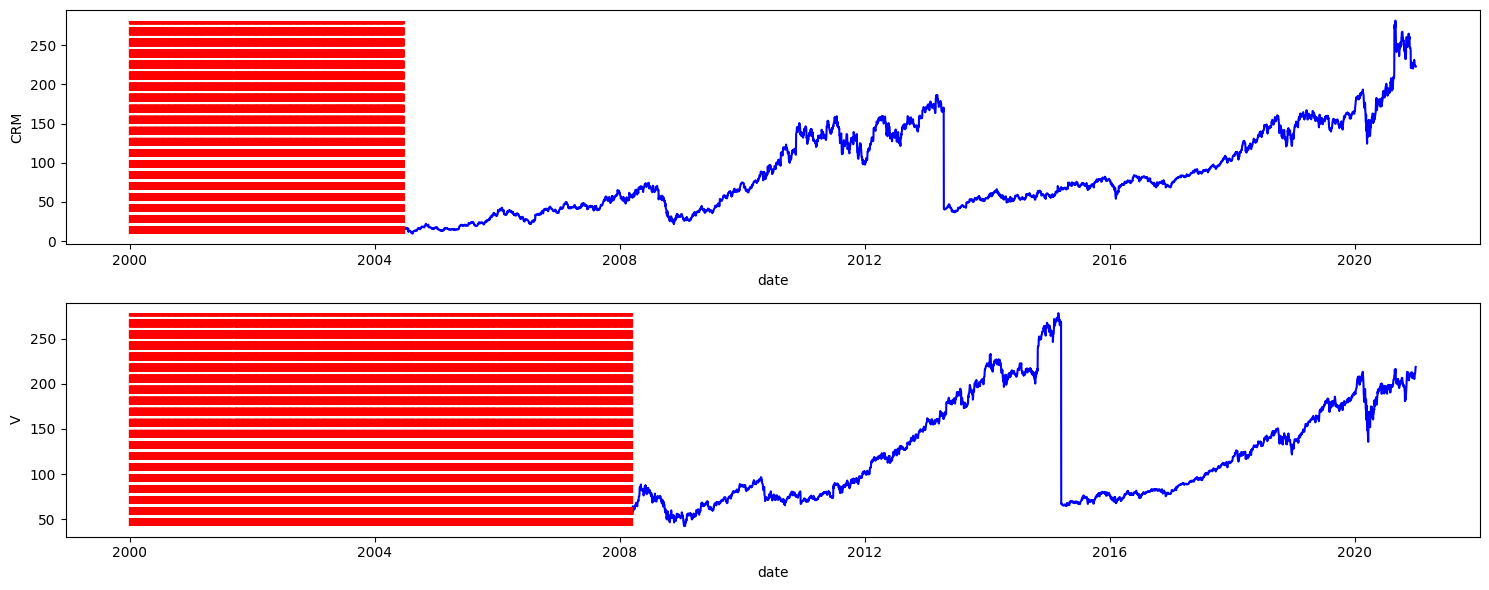

In [11]:
_, axes = plt.subplots(2, 1, figsize = (15, 6))
for col, ax in zip(['CRM', 'V'], axes):
    x_vals = np.arange(0, len(prices[col]), 1)
    missing_mask = prices.index[prices[col].isna()]
    sns.lineplot(x = prices.index, y = prices[col], color = 'blue', ax = ax)
    ax.vlines(x = missing_mask, ymin = prices[col].min(), ymax = prices[col].max(), color = 'red', linestyles = 'dashed')
plt.tight_layout()
plt.show()

The missing data is present only in the first years up to 2008, likely because previous values in the market simply don't exists, therefore we decide to focus only on data from 2010 onwards:

In [12]:
#Create price_small DataFrame with only data from 2010 onwards
prices_small = prices.drop('DOW', axis = 1)
stocks_list.remove('DOW')
stocks_array = np.array(stocks_list)
prices_small = prices_small[prices_small.index >= '2010-01-01']
prices_small.shape

(2769, 29)

As expected the data now have no missing values:

In [13]:
round(100 * prices_small.isnull().sum() / len(prices), 2)

,0
stock,
AAPL,0.0
AMGN,0.0
AXP,0.0
BA,0.0
CAT,0.0
CRM,0.0
CSCO,0.0
CVX,0.0
DIS,0.0


<h2 style="color:red">TECHNICAL ANALYSIS</h2>

<h3>Return</h3>

We compute the average daily returns for all stocks:

In [14]:
returns = prices_small.pct_change() * 100
returns.head()

stock,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.172889,-0.866251,-0.219941,3.275187,1.195559,-0.427693,-0.445525,0.708323,-0.249454,1.767969,...,0.405296,0.032310,0.397858,0.032723,-2.369002,-0.158579,-1.145904,-1.262019,-0.804290,-0.995759
2010-01-06,-1.590633,-0.751485,1.616458,3.033437,0.303797,-0.174497,-0.650936,0.012560,-0.531416,-1.067333,...,1.345533,-0.613695,-0.609663,-0.474321,-1.418877,0.984752,-1.342821,-2.860621,-0.756757,-0.223505
2010-01-07,-0.184860,-0.915654,1.181007,4.048177,0.403836,-0.443727,0.450450,-0.376742,0.031427,1.956846,...,0.159320,-1.039974,0.981445,-0.542317,1.439299,3.837685,0.930665,-0.595238,0.599129,0.056001
2010-01-08,0.664830,0.888573,-0.071463,-0.964630,1.122842,0.148568,0.529963,0.176478,0.157085,-1.891147,...,-0.053022,0.689655,-0.197418,-0.132188,-0.143944,-0.939109,0.276625,0.063032,0.135355,-0.503731


<h3>Financial Elasticity</h3>

The **financial elasticity** or beta ($\beta$) coefficient is an indicator to help determining an asset risk compared to the one of the market:</br>
$\beta = \frac{cov(r_{i}, r_{P})}{var(r_{P})}$
</br>where:
<ul>
    <li>$cov(r_{i}, r_{P})$ is the covariance of the return $r_{i}$ of the i-asset and the return of the whole market $r_{P}$.</li>
    <li>$var(r_{P})$ is the variance or $r_{P}$.</li>
</ul>
The value of $\beta$ suggests how much an asset follows the market movements:
<ul>
    <li>$\beta < 0$ means the stock has an inverse relation with the market movements.</li>
        <li>$\beta = 0$ means the stock is uncorrelated with the market movements.</li>
        <li>$0 < \beta < 1$ means the stock is less volatile than the market.</li>
            <li>$\beta = 1$ means the stock is as volatile as the market.</li>
        <li>$\beta > 1$ means the stock is more volatile than the market.</li>
</ul>

The following analysis will be made considering the last 4 years of data, from 2016 to 2020.

In [15]:
START_DATE = '2016-01-01'
END_DATE = '2020-01-01'

returns_period = returns[(returns.index >= START_DATE) & (returns.index <= END_DATE)]
market_return = returns_period.mean(axis = 1)
market_cov = returns_period.cov()
market_var = market_return.var()
beta_dict = dict.fromkeys(stocks_list)
for i in range(len(stocks_list)):
    beta = np.cov(returns_period.iloc[:,i], market_return)[1, 0] / market_var
    beta_dict[stocks_list[i]] = beta
beta_series = pd.Series(beta_dict)
beta_series.sort_values(ascending = False)

,0
CAT,1.468454
CRM,1.392686
INTC,1.343674
GS,1.330742
MSFT,1.316678
CSCO,1.269476
BA,1.251064
AAPL,1.224106
JPM,1.181457
V,1.172826


We can therefore recognize two groups:
<ul>
    <li>Less volatility: HON, HD, CVX, UNH, DIS, TRV, MRK, JNJ, WMT, MCD, PG, VZ, KO.</li>
    <li>More volatility: CAT, CRM, INTC, GS, MSFT, CSCO, BA, AAPL, JPM, V, MMM, NKE, AXP, AMGN, WBA, IBM.</li>
</ul>

<h3>Stocks clustering</h3>

An investor decision in how to configure their portfolio is determined by the amount of risk they're willing to accept and the amount of return they aim for; in a real scenario these two parameters have a positive relationship, that is:</br>
> the higher the possible return, the higher the risk (volatility) of a portfolio

A more prudent investor would therefore try and minimize the risk or at least find a sweet spot in the risk-return tradeoff: a principle often use to accomplish this is **diversification**.</br>
Simply put, diversification involves investements in different assets to create a diversified set of securities; the idea is that stocks with different behaviours mititgate risk since, if some perform worse than usual, other (negatively correlated) ones will perform better than usual.

To differentiate asset behaviour we perform clustering analysis on the stocks; since the objective is a portfolio on N = 15 stocks, we categorize the dow index in 15 clusters of similar behaviour, as described by the daily return means and covariance.</br>
We first create the dataset for the cluster analysis:

In [16]:
stock_return_mean = returns_period.mean(axis = 0)
stock_return_cov = returns_period.cov()
stock_mean_cov = pd.concat([stock_return_mean, stock_return_cov], axis = 1)
stock_mean_cov.rename(columns = {0 : 'mean'}, inplace = True)
stock_mean_cov.head()

,mean,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,0.113835,2.355609,0.783815,0.692563,0.943798,1.124955,1.314307,1.085654,0.616098,0.657347,...,0.450213,1.253134,0.778336,0.322868,0.445323,0.671179,1.066303,0.149037,0.682891,0.361863
AMGN,0.048816,0.783815,1.896241,0.617335,0.591388,0.842895,0.838232,0.726073,0.473025,0.551867,...,0.851640,0.774888,0.600300,0.323339,0.448709,0.683442,0.729165,0.331727,0.708535,0.369749
AXP,0.066128,0.692563,0.617335,1.639781,0.816575,1.005436,0.849014,0.786371,0.571592,0.550656,...,0.478213,0.823786,0.680637,0.282849,0.515496,0.638323,0.836714,0.239422,0.639046,0.348870
BA,0.094329,0.943798,0.591388,0.816575,2.708487,1.456399,1.064961,0.898385,0.794881,0.636287,...,0.449279,0.947927,0.780796,0.342904,0.537856,0.646798,0.886645,0.311243,0.626607,0.429517
CAT,0.091784,1.124955,0.842895,1.005436,1.456399,2.917907,1.147509,1.139581,1.117283,0.730247,...,0.488256,1.092840,0.863722,0.318404,0.642265,0.708087,0.949451,0.312871,0.779392,0.430318


And then apply the KMeans algorithm:

In [18]:
N_CLUSTERS = 15
model = KMeans(max_iter = 600, n_clusters = N_CLUSTERS)
model.fit(stock_mean_cov)
centroids = model.cluster_centers_
labels = model.labels_

print('Labels:\n', labels)

Labels:
 [14 13  5  6  8  4  1  5  5  2  3  5  5 10  0  2 12 12  5  0  7 11 12  0
  5  7 12  9 12]


In [19]:
clusters = []
for i in range(N_CLUSTERS):
    print('Cluster', i+1)
    cluster_idx = np.where(labels == i)
    clusters.append(stocks_array[cluster_idx])
    print(clusters[-1], '\n')

Cluster 1
['JNJ' 'MRK' 'TRV'] 

Cluster 2
['CSCO'] 

Cluster 3
['GS' 'JPM'] 

Cluster 4
['HD'] 

Cluster 5
['CRM'] 

Cluster 6
['AXP' 'CVX' 'DIS' 'HON' 'IBM' 'MMM' 'UNH'] 

Cluster 7
['BA'] 

Cluster 8
['MSFT' 'V'] 

Cluster 9
['CAT'] 

Cluster 10
['WBA'] 

Cluster 11
['INTC'] 

Cluster 12
['NKE'] 

Cluster 13
['KO' 'MCD' 'PG' 'VZ' 'WMT'] 

Cluster 14
['AMGN'] 

Cluster 15
['AAPL'] 



Now to build an optimize portfolio we just need to choose one asset for each cluster, this decision can be dictated by different reasons, we just randomly pick one as an example:

In [20]:
portfolio = [random.choice(cluster) for cluster in clusters]
portfolio

['TRV',
 'CSCO',
 'GS',
 'HD',
 'CRM',
 'MMM',
 'BA',
 'MSFT',
 'CAT',
 'WBA',
 'INTC',
 'NKE',
 'VZ',
 'AMGN',
 'AAPL']

In [21]:
portfolio.sort()
portfolio_cov = stock_return_cov[stock_return_cov.index.isin(portfolio)][portfolio].to_numpy()
portfolio_mean = stock_return_mean[portfolio].to_numpy()

<h2 style="color:red">PORTFOLIO WEIGHTS ASSIGNEMENT</h2>

Once the assets are decided an investor has to establish how to assign a weight, i.e. the portion of the total investement, to each stocks; in this analysis we consider three simple approaches:
<ul>
    <li>Equal weights portolio.</li>
    <li>Inverse volatility weights portolio.</li>
    <li>Mean variance optimized portfolio.</li>
</ul>
To rate the performance of a portfolio with stocks mean returns $r_{i}$, weights $w_{i}$, and return covariance matrix $C_{ij}$ over a time period T we compute:
<ul>
    <li>The annualized portfolio return</br>
    
> $r_{T} = \sum_{i}w_{i}\,r_{i}\times T$
</li>
</ul>
<ul>
    <li>The annualized portfolio risk</br>

> $risk = \sqrt{\sum_{i,j}w^{T}_{i}\,C_{ij}\,w_{j}\times T}$

</li>
</ul>
<ul>
    <li>The diversification ratio, which is the ratio of the weighted sum of individual asset volatilities to the portfolio's volatility</br>


> $\frac{\sum_{i}\sqrt{C_{ii}}\,w_{i}}{\sqrt{\sum_{i,j}w^{T}_{i}\,C_{ij}\,w_{j}}}$</br>


where $\sqrt{C_{ii}} = \sigma_{i}$ is the standard deviation of the returns of the i-assets.</li>
</ul>

<h3>Equal weights</h3>

In this scenario we don't differentiate between assets and assign to each of them the same weight:</br>


> $w_{i} = \frac{1}{N}$</br>


where N is the number of assets.

In [22]:
def risk_2(weights, cov_matrix):
    return np.matmul(np.matmul(weights, cov_matrix), np.transpose(weights))

In [23]:
ew_weights = np.ones(( len(portfolio))) * (1./len(portfolio))

ew_portfolio_risk = np.sqrt(risk_2(ew_weights, portfolio_cov))
ew_annual_portfolio_risk = ew_portfolio_risk * np.sqrt(251)
ew_portfolio_return = np.matmul(ew_weights, np.transpose(portfolio_mean))
ew_annual_portfolio_return = ew_portfolio_return * 251
ew_diversification_index = np.matmul(np.sqrt(np.diagonal(portfolio_cov)), ew_weights) / ew_portfolio_risk

print(f'Annualized Portfolio Risk: {ew_annual_portfolio_risk:4.2f}%\n')
print(f'Annualized Portfolio Return: {ew_annual_portfolio_return:4.2f}%\n')
print(f'Diversification Ratio: {ew_diversification_index :4.2f}%')

Annualized Portfolio Risk: 14.78%

Annualized Portfolio Return: 14.98%

Diversification Ratio: 1.54%


<h3>Inverse volatility weights</h3>

In an inverse volatility weighted portfolio we assign weights inversely proportional to their volatility, that is:</br>



> $w_{i} = \frac{\sigma^{-1}_{i}}{\sum_{j}\sigma^{-1}_{j}}$




In [24]:
iv_weights = (1./np.sqrt(np.diagonal(portfolio_cov))) / np.sum(1./np.sqrt(np.diagonal(portfolio_cov)))

iv_portfolio_risk = np.sqrt(risk_2(iv_weights, portfolio_cov))
iv_annual_portfolio_risk = iv_portfolio_risk * np.sqrt(251)
iv_portfolio_return = np.matmul(iv_weights, np.transpose(portfolio_mean))
iv_annual_portfolio_return = iv_portfolio_return * 251
iv_diversification_index = np.matmul(np.sqrt(np.diagonal(portfolio_cov)), iv_weights) / iv_portfolio_risk

print(f'Annualized Portfolio Risk: {iv_annual_portfolio_risk:4.2f}%\n')
print(f'Annualized Portfolio Return: {iv_annual_portfolio_return:4.2f}%\n')
print(f'Diversification Ratio: {iv_diversification_index :4.2f}%')

Annualized Portfolio Risk: 14.32%

Annualized Portfolio Return: 14.35%

Diversification Ratio: 1.56%


<h3>Mean-Variance Optimization</h3>

The Markowitz model, also caled mean-variance optimization model is a way to determine the optimal weights to maximize the return while minimizing the risk.</br>
The model therefore aims to solve a multi-objective optimization problem, i.e.:</br>
> $max(\sum_{i}w_{i}\,r_{i})$</br>
> $min(\sqrt{\sum_{ij}w_{i}\,C_{ij}\,w_{j}})$</br>
> $\sum_{i}w_{i} = 1$</br>
> $0 \leq w_{i} \leq 1$</br>

where the last two equations are basic constraint, requiring that the sum of all fraction of the total investement is 1 and that each weight is between 0 and 1 (included).

To solve the problem above we'll make use the SciPy library to define three functions:</br>
<ul>
    <li>maximize_return is used to find the maximum possible return $R_{max-ret}$ giving the constraints.</li>
    <li>minimize_risk is used to find the return associate with the minimum possible risk $R_{min-risk}$ giving the constraints.</li>
    <li>minmax_constraint is used to find the weights which minimize the risk while having a return R such as  $R_{min-risk} \leq R \leq R_{max-ret}$.</li>
</ul>

In [25]:
def maximize_return(returns_mean, portfolio_size):
    c = -1. * returns_mean
    A = np.ones([portfolio_size,1]).T
    b = [1]
    return linprog(c, A_ub = A, b_ub = b, bounds = (0, 1), method = "simplex")

In [26]:
def minimize_risk(portfolio_cov, portfolio_size):

    def constraint_eq(x, b = 1):
        A = np.ones(x.shape)
        return np.matmul(A, x.T) - b

    x_init = np.repeat(0.1, portfolio_size)
    constraint_dict = {'type' : 'eq', 'fun' : constraint_eq}
    bounds_vals = tuple([(0, 1) for x in x_init])
    opt = optimize.minimize(risk_2, x0 = x_init, args = (portfolio_cov), bounds = bounds_vals,
                           constraints = constraint_dict, tol = 10**-3)
    return opt

In [27]:
def minimax_constraint(return_means, portfolio_cov, portfolio_size, R):

    def constraint_eq(x, b = 1):
        A = np.ones(x.shape)
        return np.matmul(A, x.T) - b

    def constraint_ineq(x, return_means, R):
        return np.matmul(return_means, x.T) - R

    x_init = np.repeat(0.1, portfolio_size)
    constraint_dict = ({'type' : 'eq', 'fun' : constraint_eq},
                       {'type' : 'ineq', 'fun' : constraint_ineq, 'args' : (return_means, R)})
    bounds_vals = tuple([(0, 1) for x in x_init])
    opt = optimize.minimize(risk_2, x0 = x_init, args = (portfolio_cov), method ='trust-constr', bounds = bounds_vals,
                           constraints = constraint_dict, tol = 10**-3)
    return opt

<h3>Maximized return</h3>

In [28]:
result_max = maximize_return(portfolio_mean, len(portfolio))
max_return_weights = result_max.x
max_portfolio_return = np.matmul(portfolio_mean.T, max_return_weights)
print(f'Max return portfolio return: {max_portfolio_return:.2f}')

Max return portfolio return: 0.11


<h3>Minimized risk</h3>

In [29]:
result_min = minimize_risk(portfolio_cov, len(portfolio))
min_risk_weights = result_min.x
min_risk_portfolio_return = np.matmul(portfolio_mean.T, min_risk_weights)
print(f'Min risk portfolio return: {min_risk_portfolio_return:.2f}')

Min risk portfolio return: 0.04


<h3>Mean-variance optimized</h3>

Now we're ready to actually apply the mean-variance optimization model: for every value of return between the lower an upper bounds previously defined we compute the optimal weights, storing their values with the minimum risk associated; finally we can summarize the results in a return-risk frontier plot.  

In [31]:
step = 1e-3
low = min_risk_portfolio_return
high = max_portfolio_return

#initialize three lists: optimal weight set and risk-return point set
#     -optimal_weights stores the optimal weights for each return
#     -min_risk_point stores the risk values for each return
#     -portfolio_return_point stores the return values
optimal_weights = []
min_risk_point = []
portfolio_return_point =[]

#for each possible return value we compute the optimal weights
while (low < high):

    portfolio_return_point.append(low)

    result_constr = minimax_constraint(portfolio_mean, portfolio_cov, len(portfolio), low)
    optimal_weights.append(result_constr.x)

    low = low + step


optimal_weights_array = np.array(optimal_weights)

#compute the annualized risk
min_risk_point = np.diagonal(np.matmul((np.matmul(optimal_weights_array,portfolio_cov)), np.transpose(optimal_weights_array)))
risk_point =   np.sqrt(min_risk_point * 251)

#compute the annualized return
return_point = 251 * np.array(portfolio_return_point)

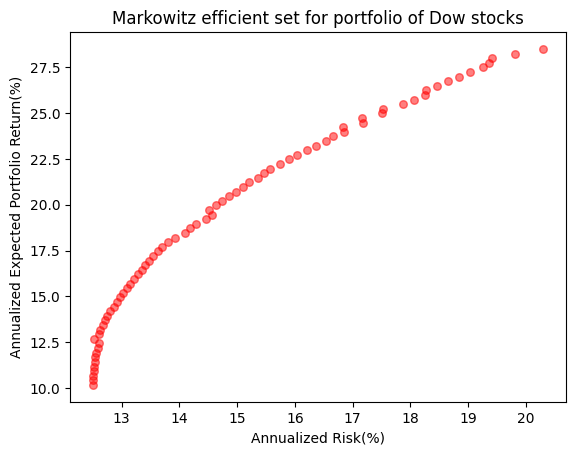

In [32]:
plt.title('Markowitz efficient set for portfolio of Dow stocks')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(risk_point, return_point, s = 30, c = 'red', alpha = 0.5)
plt.show()